### Validation Set noise - Tennessee Eastman Process Dataset

In [3]:
import numpy as np 
import time
import os 
import matplotlib.pyplot as plt
from HPO.utils.model import NetworkMain
from HPO.utils.DARTS_utils import config_space_2_DARTS
from HPO.utils.FCN import FCN 
import pandas as pd
import torch
from HPO.data.teps_datasets import Train_TEPS , Test_TEPS
import torch.nn as nn
from torch import Tensor
from torch.utils.data import DataLoader, SubsetRandomSampler
import random
import HPO.utils.augmentation as aug
from HPO.utils.train_utils import collate_fn_padd
from HPO.utils.train import train_model, auto_train_model
from HPO.utils.weight_freezing import freeze_FCN, freeze_resnet
from HPO.utils.ResNet1d import resnet18
from HPO.utils.files import save_obj
from queue import Empty
from sklearn.model_selection import StratifiedKFold as KFold
from collections import namedtuple
from HPO.utils.worker_score import Evaluator 
from HPO.utils.worker_utils import LivePlot
import seaborn as sns
Genotype = namedtuple('Genotype', 'normal normal_concat reduce reduce_concat')
model = 0
torch.cuda.empty_cache()

In [26]:
def _compute(hyperparameter,budget = 1, in_model = None , train_path = None,  test_path = None, cuda_device = None,plot_queue = None, model_id = None, binary = False):
  ### Configuration 
  THRESHOLD = 0.4 #Cut off for classification
  batch_size = 64
  if cuda_device == None:
     cuda_device = 1# torch.cuda.current_device()
  
  ##Set up augmentations##
  jitter = aug.Jitter(device = cuda_device,sigma = 0.125, rate = 0.5)
  crop = aug.Crop(device = cuda_device, rate = 0.8, crop_min = 0.3 , crop_max = 0.98)
  scaling = aug.Scaling(device = cuda_device)
  window_warp = aug.WindowWarp(device = cuda_device,rate = 0.5)
  cut_out = aug.CutOut(device = cuda_device)
  mix_up = aug.MixUp(device = cuda_device,m = 0.2, rate = 0.3)
  augmentations = [jitter,crop,scaling, window_warp, cut_out]

  dataset_train = Train_TEPS(augmentations= augmentations, samples_per_class = 500,device = cuda_device,one_hot = False,binary = False)

  #dataset_test_full = Test_TEPS()
  torch.cuda.set_device(cuda_device)

  print("Cuda Device Value: ", cuda_device)
  gen = config_space_2_DARTS(hyperparameter,reduction = True)
  print(gen)


  n_classes = dataset_train.get_n_classes()
  multibatch = False
  torch.cuda.empty_cache()
  trainloader = torch.utils.data.DataLoader(
                      dataset_train,collate_fn = collate_fn_padd,shuffle = True,
                      batch_size=batch_size, drop_last = True)


  model = NetworkMain(dataset_train.get_n_features(),hyperparameter["channels"],num_classes= dataset_train.get_n_classes() , 
                      layers = hyperparameter["layers"], auxiliary = False,drop_prob = hyperparameter["p"], genotype = gen, binary = binary)
  model = model.cuda(device = cuda_device)
  """
  ### Train the model
  """
  train_model(model , hyperparameter, trainloader , hyperparameter["epochs"], batch_size , cuda_device, graph = plot_queue, binary = binary) 
  return model

In [126]:
from HPO.searchspaces.DARTS_NAS_config import init_config
cs = init_config()
from HPO.searchspaces.DARTS_new_config import init_config as init_config_hpo
cs_hpo = init_config_hpo()
results_df = pd.DataFrame(columns = ["labels","prediction","risk","augmented","ID"])

In [127]:
cs_hpo.sample_configuration()

Configuration(values={
  'T_0': 5,
  'T_mult': 1,
  'c1_weight': 4.216876974532806,
  'epochs': 201,
  'jitter': 0.058656491380420554,
  'jitter_rate': 0.656119574712994,
  'lr': 0.03785136052901154,
  'p': 0.2825265432305704,
  'scaling': 0.23573522412939873,
  'scaling_rate': 0.05509902387109319,
  'window_warp_num': 6,
  'window_warp_rate': 0.63142732974657,
})

In [128]:
##Main Loop
import HPO.utils.augmentation as aug
if len(results_df["ID"]) > 0:
    iteration = results_df["ID"].iloc[-1]
else:
    iteration = -1
for ID in range(iteration+1, iteration+20):
    hyperparameter = cs.sample_configuration().get_dictionary()
    hpo = {'channels': 32, 'lr': 0.0025170869707739693, 'p': 0.00, 'epochs': 5, 'layers': 3}
    hyperparameter.update(hpo)
    model = _compute(hyperparameter)
    cuda_device = 1
    binary = False
    THRESHOLD = 0.4
    jitter = aug.Jitter(device = cuda_device,sigma = 0.125, rate = 0.5)
    crop = aug.Crop(device = cuda_device, rate = 0.5, crop_min = 0.3 , crop_max = 0.98)
    scaling = aug.Scaling(device = cuda_device)
    window_warp = aug.WindowWarp(device = cuda_device,rate = 0.9)
    cut_out = aug.CutOut(device = cuda_device)
    mix_up = aug.MixUp(device = cuda_device,m = 0.2, rate = 0.3)
    augmentations = [jitter,crop]
    batch_size = 32
    model.eval()
    dataset_test = Test_TEPS(binary = False,samples_per_class = 500, one_hot = False)
    testloader = torch.utils.data.DataLoader(
                      dataset_test,collate_fn = collate_fn_padd,shuffle = True,
                      batch_size=batch_size,drop_last = True)
    
    n_classes = dataset_test.get_n_classes()
    evaluator = Evaluator(batch_size, n_classes,cuda_device,testloader = testloader) 
    evaluator.forward_pass(model, testloader,binary)
    evaluator.predictions(model_is_binary = binary , THRESHOLD = THRESHOLD)
    total = evaluator.T()
    acc  =  evaluator.T_ACC()
    recall = evaluator.TPR(1)
    recall_total = evaluator.P(1)
    print("Accuracy: ", "%.4f" % ((acc)*100), "%")
    print("Recall: ", "%.4f" % ((recall)*100), "%")
    df = pd.DataFrame(columns = ["labels","prediction"])
    df["labels"] =evaluator.labels.squeeze().astype("int") 
    df["prediction"] = evaluator.prediction
    df["risk"] = (df["labels"] == df["prediction"]).astype("int")
    df["augmentation"] = 0
    df["ID"] = ID
    results_df = results_df.append(df)
    
    jitter = aug.Jitter(device = cuda_device,sigma = 0.125, rate = 0.5)
    crop = aug.Crop(device = cuda_device, rate = 0.95, crop_min = 0.25 , crop_max = 0.98)
    scaling = aug.Scaling(device = cuda_device)
    window_warp = aug.WindowWarp(device = cuda_device,rate = 0.5)
    cut_out = aug.CutOut(device = cuda_device)
    mix_up = aug.MixUp(device = cuda_device,m = 0.2, rate = 0.3)
    augmentations = [crop,jitter]
    batch_size = 256
    model.eval()
    dataset_test = Test_TEPS(binary = False,samples_per_class = 500, one_hot = False,augmentations = augmentations,samples_per_epoch = 20)
    testloader = torch.utils.data.DataLoader(
                      dataset_test,collate_fn = collate_fn_padd,shuffle = False,
                      batch_size=batch_size,drop_last = True)
    evaluator = Evaluator(batch_size, n_classes,cuda_device,testloader = testloader) 
    evaluator.forward_pass(model, testloader,binary)
    evaluator.predictions(model_is_binary = binary , THRESHOLD = THRESHOLD)
    df_aug = pd.DataFrame(columns = ["labels","prediction"])
    df_aug["labels"] =evaluator.labels.squeeze().astype("int") 
    df_aug["prediction"] = evaluator.prediction
    df_aug["risk"] = (df_aug["labels"] == df_aug["prediction"]).astype("int")
    df_aug["origin_id"] = df_aug.index % 10499
    df_aug["augmentation"] = 1
    df_aug["ID"] = ID
    results_df = results_df.append(df_aug)

Cuda Device Value:  1
Genotype(normal=[('sep_conv_7x7', 1), ('skip_connect', 0), ('sep_conv_5x5', 2), ('sep_conv_7x7', 0), ('none', 2), ('avg_pool_3x3', 0), ('dil_conv_3x3', 4), ('sep_conv_7x7', 1)], normal_concat=[3, 5], reduce=[('sep_conv_7x7', 0), ('dil_conv_3x3', 1), ('sep_conv_5x5', 0), ('skip_connect', 2), ('sep_conv_7x7', 1), ('none', 0), ('avg_pool_3x3', 1), ('sep_conv_7x7', 2)], reduce_concat=[3, 4, 5])
Epoch ( 4 / 5 ) Accuracy:  0.92 Iteration(s) ( 160 / 164 ) Loss:  0.12  Correct / Total : 7778 / 8448 2 
Num epochs: 5
[[  0.   0.   0. 478.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  22.   0.   0.   0.   0.   0.]
 [  0. 499.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0. 499.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0. 480.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  20.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0. 500.   0.  

In [129]:
#Sampling Configuration
SAMPLE_SIZE_PER_CLASS = 200
NUM_SAMPLES = 100

df_samples = pd.DataFrame(columns = ["Augmented", "Unaugmented","Model"])

for i in np.unique(results_df["ID"]):
    print(i)
    sample_means = []
    sample_means_nor = []
    df = results_df[results_df["ID"] == i]
    df = df[df["augmentation"] == 0]
    for _ in range(NUM_SAMPLES):
        sample_means_nor.append(df.groupby('labels', group_keys=False).apply(lambda x: x.sample(SAMPLE_SIZE_PER_CLASS,replace = False))["risk"].mean())
    
    df = results_df[results_df["ID"] == i]
    df = df[df["augmentation"] == 1]
    print(df)
    for _ in range(NUM_SAMPLES):
        sample = df[:10500].groupby('labels', group_keys=False).apply(lambda x: x.sample(SAMPLE_SIZE_PER_CLASS,replace = False))
        sample_means.append(df[df["origin_id"].isin(sample["origin_id"])]["risk"].mean())
    aug_mean = np.mean(sample_means) 
    aug_std = np.std(sample_means)

    unaug_mean = np.mean(sample_means_nor) 
    unaug_std = np.std(sample_means_nor)

    aug_distribution = np.random.normal(aug_mean,aug_std,size = 1000)
    unaug_distribution = np.random.normal(unaug_mean,unaug_std,size = 1000)
    print("Unaugmentated STD: {}".format(unaug_std))
    print("Unaugmentated Mean: {}".format(unaug_mean))
    print("augmentated STD: {}".format(aug_std))
    print("augmentated Mean: {}".format(aug_mean))
    df_samples = df_samples.append(pd.DataFrame({"Augmented": aug_distribution,"Unaugmented":unaug_distribution,"Model":i}),ignore_index = True)
        

0
       labels prediction risk augmented ID  augmentation  origin_id
0           4          4    1       NaN  0           1.0        0.0
1           0          3    0       NaN  0           1.0        1.0
2          12         12    1       NaN  0           1.0        2.0
3          13         13    1       NaN  0           1.0        3.0
4           2          2    1       NaN  0           1.0        4.0
...       ...        ...  ...       ... ..           ...        ...
209915      0          3    0       NaN  0           1.0    10434.0
209916      1          1    1       NaN  0           1.0    10435.0
209917     17         17    1       NaN  0           1.0    10436.0
209918     20         20    1       NaN  0           1.0    10437.0
209919     18         18    1       NaN  0           1.0    10438.0

[209920 rows x 7 columns]
Unaugmentated STD: 0.00118890133928675
Unaugmentated Mean: 0.9418309523809522
augmentated STD: 0.000881749430078286
augmentated Mean: 0.9343236711282354
1


In [130]:
df_samples

,Augmented,Unaugmented,Model
0,0.935494,0.942484,0
1,0.933584,0.941708,0
2,0.934607,0.943705,0
3,0.935967,0.940585,0
4,0.933660,0.941113,0
...,...,...,...
18995,0.924997,0.930144,18
18996,0.925987,0.929215,18
18997,0.924302,0.929509,18
18998,0.927059,0.930490,18


In [77]:
import scipy
import math
x_bar = df_samples[df_samples["Model"] == 1]["Unaugmented"].mean()
sigma = df_samples[df_samples["Model"] == 1]["Unaugmented"].std()
n = len(df_samples[df_samples["Model"] == 1]["Unaugmented"])
print((x_bar , - scipy.stats.norm.ppf(0.975)*sigma/math.sqrt(n), + scipy.stats.norm.ppf(0.975)*sigma/math.sqrt(n)))
# [1] 4.804931 5.424726
#94.4836

import scipy
import math
x_bar = df_samples[df_samples["Model"] == 1]["Augmented"].mean()
sigma = df_samples[df_samples["Model"] == 1]["Augmented"].std()
n = len(df_samples[df_samples["Model"] == 1]["Augmented"])
(x_bar , - scipy.stats.norm.ppf(0.975)*sigma/math.sqrt(n), + scipy.stats.norm.ppf(0.975)*sigma/math.sqrt(n))



(0.944311256302977, -0.0004391320060690249, 0.0004391320060690249)


(0.9421073090326769, -0.0002957313587794905, 0.0002957313587794905)

<Figure size 3600x2160 with 0 Axes>

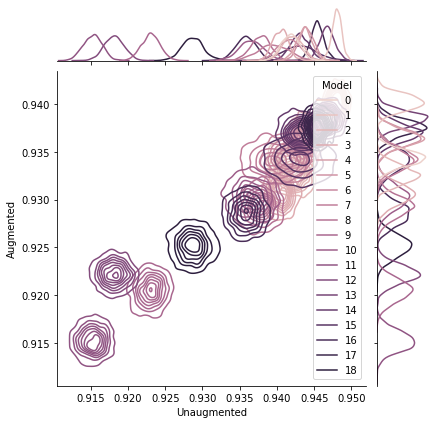

In [131]:
plt.figure(figsize = (50,30))
sns.jointplot(data = df_samples,x = "Unaugmented",y = "Augmented",hue = "Model", kind = "kde")

In [132]:
df = results_df[results_df["ID"] == 0]
df = df[df["augmentation"] == 0]

<AxesSubplot:xlabel='Augmented', ylabel='Unaugmented'>

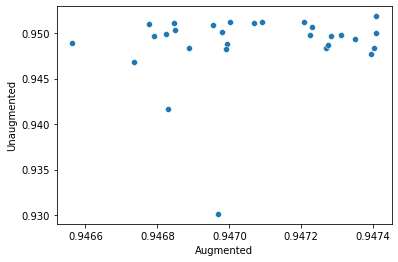

In [18]:
sns.scatterplot(data = df_samples.groupby("Model").mean(),x = "Augmented",y = "Unaugmented" )

In [133]:
##Corrolations
corr_df = pd.DataFrame(columns = ["aug","normal","mean"])
NUM_SAMPLES = 500
SAMPLE_SIZE_PER_CLASS = 200

normal = []
aug = []
means = []
model = []
for i in np.unique(results_df["ID"]):
    print(i)
    sample_means = []
    sample_means_nor = []
    df = results_df[results_df["ID"] == i]
    df = df[df["augmentation"] == 0]

    for _ in range(NUM_SAMPLES):
        normal.append(df.groupby('labels', group_keys=False).apply(lambda x: x.sample(SAMPLE_SIZE_PER_CLASS,replace = False))["risk"].mean())
        means.append(df["risk"].mean())
        model.append(i)
    df = results_df[results_df["ID"] == i]
    df = df[df["augmentation"] == 1]
    
    for _ in range(NUM_SAMPLES):
        sample = df[:10500].groupby('labels', group_keys=False).apply(lambda x: x.sample(SAMPLE_SIZE_PER_CLASS,replace = False))
        aug.append(df[df["origin_id"].isin(sample["origin_id"])]["risk"].mean())
        

corr_df = pd.DataFrame({"aug":aug,"normal": normal,"mean":means})

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18


In [134]:
corr_df = pd.DataFrame({"aug":aug,"normal": normal,"mean":means})


In [135]:
corr_df.corr("spearman")

,aug,normal,mean
aug,1.000000,0.917100,0.949323
normal,0.917100,1.000000,0.958291
mean,0.949323,0.958291,1.000000


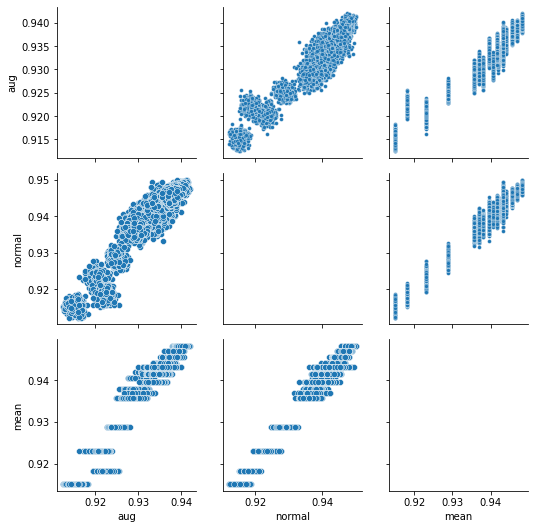

In [136]:
g =sns.PairGrid(corr_df)
g.map_upper(sns.scatterplot, s=15)
g.map_lower(sns.scatterplot)
g.map_diag(sns.scatterplot, lw=2)